# ZXZ Hamiltonian Engineering with Quantum Optimal Control

This notebook demonstrates engineering effective three-body ZXZ Hamiltonian dynamics on Rydberg atom chains using direct trajectory optimization.

**Key Objectives:**
- Transform native two-body Rydberg interactions into effective three-body ZXZ dynamics
- Use global control pulses (Rabi frequency $\Omega(t)$ and detuning $\Delta(t)$) 
- Operate outside the blockade regime while respecting hardware constraints
- Achieve high-fidelity synthesis of symmetry-protected topological phases

**Physical System:**
- Target: $H_{\text{ZXZ}} = J_{\text{eff}} \sum_j Z_{j-1} X_j Z_{j+1}$ (cluster-Ising model)
- Native (Equation 19): $\frac{H(t)}{\hbar} = \frac{\Omega(t)}{2} \sum_i (|g_i\rangle\langle r_i| + |r_i\rangle\langle g_i|) - \Delta(t) \sum_i |r_i\rangle\langle r_i| + \sum_{i<j} \frac{C_6}{|r_i - r_j|^6} |r_i\rangle\langle r_i| |r_j\rangle\langle r_j|$
- Atoms spaced at $8.9 \, \mu\text{m}$ (outside $8.37 \, \mu\text{m}$ blockade radius)

In [ ]:
using Piccolo
using DataInterpolations
using LinearAlgebra
using SparseArrays
using CairoMakie

## 1. Dependencies and Setup

Import required packages and load the ZXZAtoms module containing trajectory and plotting utilities.

In [3]:
include("src/ZXZAtoms.jl")
using .ZXZAtoms

In [4]:
Z = GATES[:Z]
Y = GATES[:Y]
X = GATES[:X]
n = 0.5 * (GATES[:I] + GATES[:Z])  # Number operator: |1⟩⟨1|
P = 0.5 * (GATES[:I] - GATES[:Z])  # Projection operator: |0⟩⟨0|

H_eff_name = "ZXZ"
N_atoms = 3
ignore_Y_drive = true
dist = 8.9  # μm spacing
T = 26      # Time samples

if N_atoms == 3
    H_eff = operator_from_string("ZXZ")
elseif N_atoms == 4
    H_eff = operator_from_string("ZXZI") + operator_from_string("IZXZ")
elseif N_atoms == 5
    H_eff = operator_from_string("ZXZII") + operator_from_string("IZXZI") + operator_from_string("IIZXZ")
end

sparse(H_eff)

8×8 SparseMatrixCSC{ComplexF64, Int64} with 8 stored entries:
     ⋅           ⋅      1.0+0.0im  …      ⋅           ⋅          ⋅    
     ⋅           ⋅          ⋅             ⋅           ⋅          ⋅    
 1.0+0.0im       ⋅          ⋅             ⋅           ⋅          ⋅    
     ⋅      -1.0+0.0im      ⋅             ⋅           ⋅          ⋅    
     ⋅           ⋅          ⋅             ⋅      -1.0+0.0im      ⋅    
     ⋅           ⋅          ⋅      …      ⋅           ⋅      1.0-0.0im
     ⋅           ⋅          ⋅             ⋅           ⋅          ⋅    
     ⋅           ⋅          ⋅         1.0-0.0im       ⋅          ⋅    

## 2. System Definition

Define the target ZXZ Hamiltonian and system parameters for the quantum control problem.

We construct the target unitary evolution $U_{\text{goal}} = \exp(-i\theta H_{\text{eff}})$ where $\theta = 0.8$ is the evolution parameter, and set up the Rydberg chain system with van der Waals interactions $V_{j\ell} = C_6/|r_j - r_\ell|^6$.

In [5]:
θ = 0.8  # Evolution parameter
U_goal = sparse(exp(-im * θ * H_eff))
sys = RydbergChainSystem(N=N_atoms, distance=dist, ignore_Y_drive=ignore_Y_drive)

# Control amplitude bounds
Rabi_max = 15.7   # MHz, maximum Rabi frequency Ω_max
Delta_max = 100.0 # MHz, maximum detuning |Δ_max|

if ignore_Y_drive
    # 2D control: [Ω(t), Δ(t)]
    a_bounds = (
        [0.0, -Delta_max],
        [Rabi_max, Delta_max],
    )
else
    # 3D control: [Ω_x(t), Ω_y(t), Δ(t)]
    Rabi_max_mod = Rabi_max / sqrt(2)
    a_bounds = (
        [-Rabi_max_mod, -Rabi_max_mod, -Delta_max],
        [Rabi_max_mod, Rabi_max_mod, Delta_max]
    )
end

([0.0, -100.0], [15.7, 100.0])

## 3. Initial Trajectory Setup

Create an initial control trajectory with random controls as the starting point for optimization.

The trajectory uses linear interpolation between control points to create smooth, differentiable control functions $\Omega(t)$ and $\Delta(t)$ with time step $\Delta t = 0.05$.

In [6]:
dt = 0.05  # Time step Δt
u = vcat(rand(1, T), 2 .* rand(1, T).- 1)  # Random initial controls
Δt = fill(dt, 1, T)
times = [(k-1) * 0.05 for k in 1:T]

da = 2.0

Id = sparse(I(size(U_goal, 1)))
G(a, t) = sys.G(a)  # Generator function H(t) = G(a(t))
Ĝ(a, t) = kron(Id, sys.G(a))  # Isomorphic generator

# Linear interpolation for smooth control functions
u_fn = t -> begin
    [LinearInterpolation(u[j,:], times)(t) for j = 1:2]
end

traj = unitary_rollout_trajectory(u_fn, G, times[end]; 
    samples=T,
    control_bounds=a_bounds,
    Δt_min=dt, 
    Δt_max=2.0dt
) 

update_bound!(traj, :u, a_bounds)

## 4. Optimization Problem Setup

Configure the cost function and constraints for the direct trajectory optimization.

The objective function combines:
- **Fidelity term**: $Q \cdot \mathcal{I}(U_{\text{final}}, U_{\text{goal}})$ where $\mathcal{I} = 1 - \mathcal{F}$ and $\mathcal{F} = \frac{|\text{tr}(U^\dagger_{\text{goal}} U_{\text{final}})|^2}{d^2}$ is the trace fidelity
- **Regularization**: $R_u \sum_t \|u(t)\|^2$ to penalize large control amplitudes

In [7]:
Q = 1.0e3     # Fidelity weight (high priority on gate accuracy)
R_u = 1.0     # Control amplitude regularization
# R_du = 0.0    # First derivative regularization (smoothness)
# R_ddu = 1.0e-7 # Second derivative regularization (bandwidth)

# Unitary infidelity objective: I = 1 - F where F = |tr(U†_goal U_final)|²/d²
J = UnitaryInfidelityObjective(U_goal, :Ũ⃗, traj; Q=Q)
J += QuadraticRegularizer(:u, traj, R_u)
# J += QuadraticRegularizer(:du, traj, R_du)
# J += QuadraticRegularizer(:ddu, traj, R_ddu)

# Schrödinger equation constraint: d|ψ⟩/dt = -iH(t)|ψ⟩
integrators = [
    TimeDependentBilinearIntegrator(Ĝ, traj, :Ũ⃗, :u, :t; linear_spline=true)
    # DerivativeIntegrator(traj, :u, :du),
    # DerivativeIntegrator(traj, :du, :ddu)
]

prob = DirectTrajOptProblem(traj, J, integrators)

DirectTrajOptProblem
   timesteps            = 26
   duration             = 1.25
   variable names       = (:Ũ⃗, :u, :Δt, :t)
   knot point dimension = 132


## 5. Optimization Execution

Run the direct trajectory optimization to find optimal control pulses.

The optimization uses IPOPT (Interior Point Optimizer) to solve the constrained nonlinear programming problem, finding control sequences $\{\Omega(t), \Delta(t)\}$ that maximize the trace fidelity $\mathcal{F} = \frac{|\text{tr}(U^\dagger_{\text{goal}} U_{\text{final}})|^2}{d^2}$.

In [8]:
# Check initial fidelity before optimization
println("Initial fidelity: ", unitary_fidelity(iso_vec_to_operator(traj[end].Ũ⃗), U_goal))

max_iter = 200

# Run optimization with IPOPT solver
DirectTrajOpt.solve!(prob; 
    max_iter=max_iter, 
    options=IpoptOptions(
        recalc_y="yes", 
        recalc_y_feas_tol=1e8,
        eval_hessian=false
    )
)

Initial fidelity: 0.2809384828736189
    initializing optimizer...
    initializing optimizer...
        applying constraint: 
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of u
        applying constraint: final value of u
        applying constraint: bounds on Ũ⃗
        applying constraint: bounds on Δt
        applying constraint: bounds on u
initial value of Ũ⃗
        applying constraint: initial value of u
        applying constraint: final value of u
        applying constraint: bounds on Ũ⃗
        applying constraint: bounds on Δt
        applying constraint: bounds on u

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
***********************************************************

## 6. Results and Validation

Analyze the optimization results and validate the engineered control pulses.

We check the final gate fidelity and verify that the optimized control sequence indeed generates the target ZXZ Hamiltonian evolution with high precision.

In [9]:
# Check final optimized fidelity
println("Final optimized fidelity: ", unitary_fidelity(iso_vec_to_operator(prob.trajectory[end].Ũ⃗), U_goal))

Final optimized fidelity: 0.7964479285425513


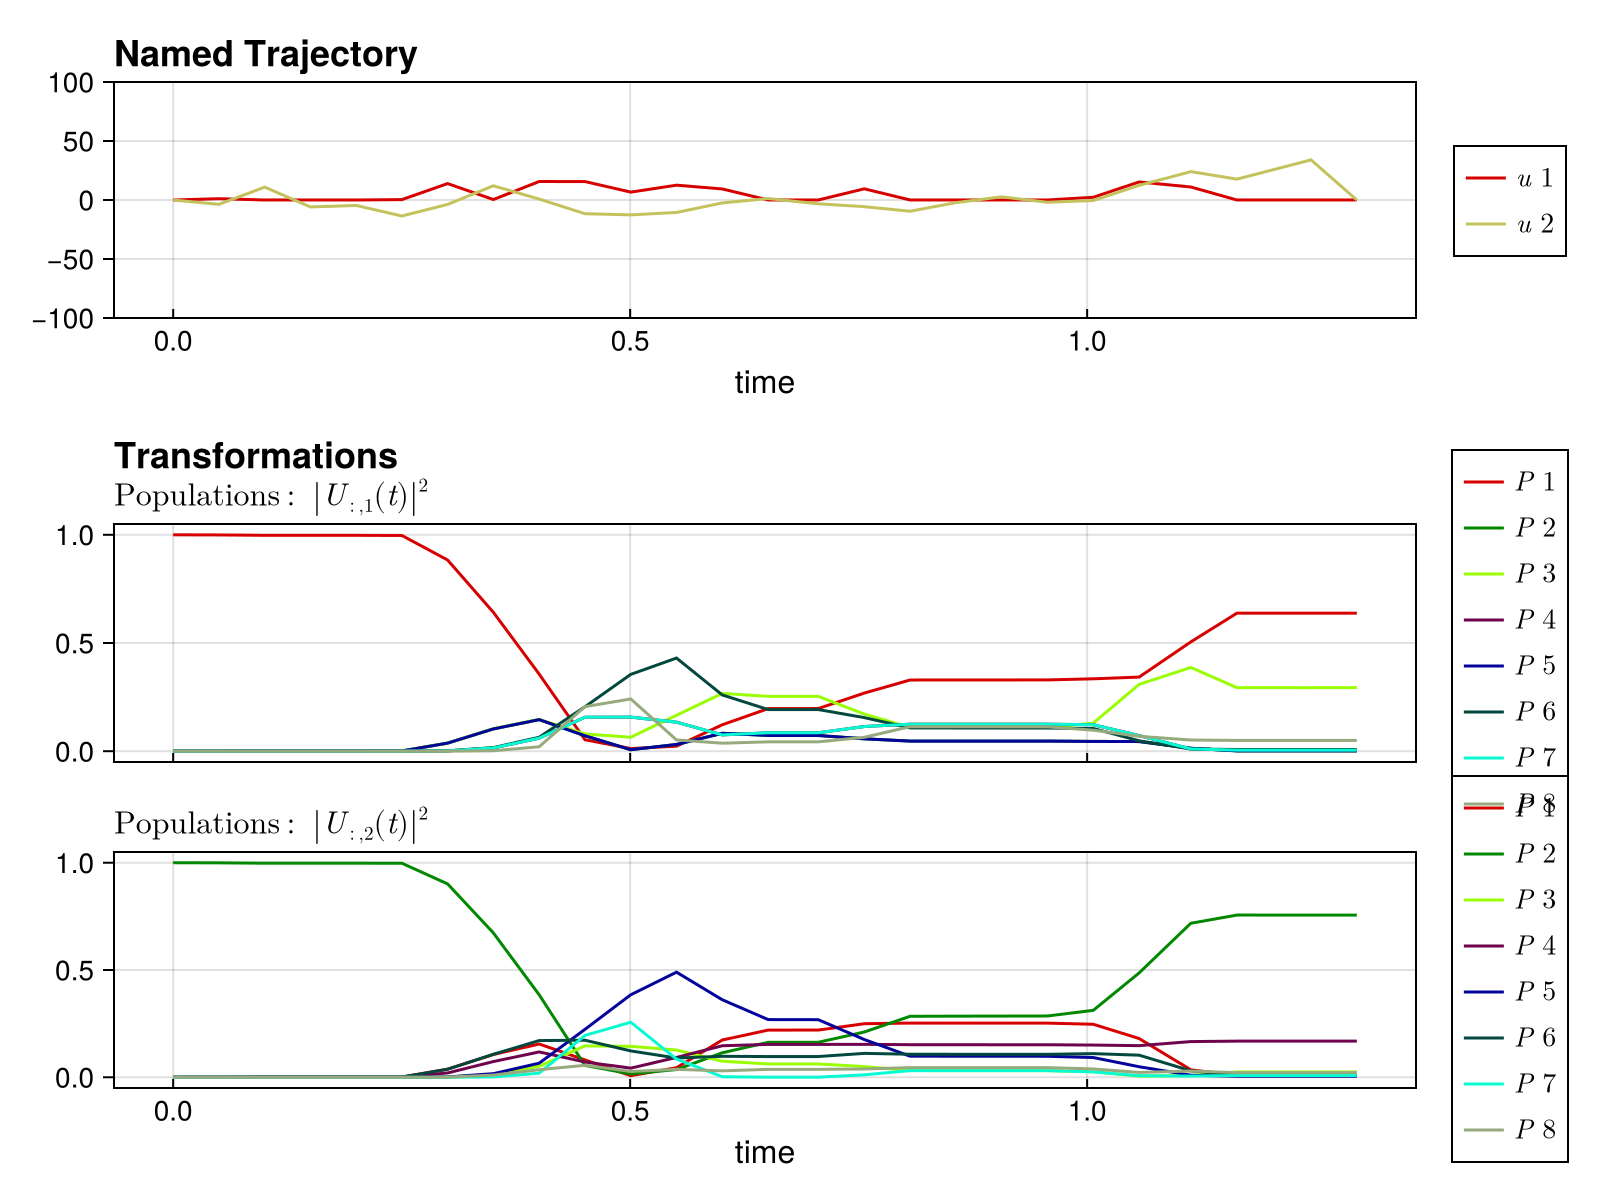

In [10]:
plot_unitary_populations(prob.trajectory; control_name=:u)

In [11]:
# Validation rollout: Forward integrate optimized controls
rollout_traj = unitary_rollout_trajectory(
    t -> [LinearInterpolation(prob.trajectory.u[j,:], get_times(prob.trajectory))(t) for j = 1:2],
    G,
    get_times(prob.trajectory)[end];
    samples=T
)

# Verify fidelity of independent rollout simulation
println("Rollout validation fidelity: ", unitary_fidelity(iso_vec_to_operator(rollout_traj[end].Ũ⃗), U_goal))

Rollout validation fidelity: 0.7945191363423213



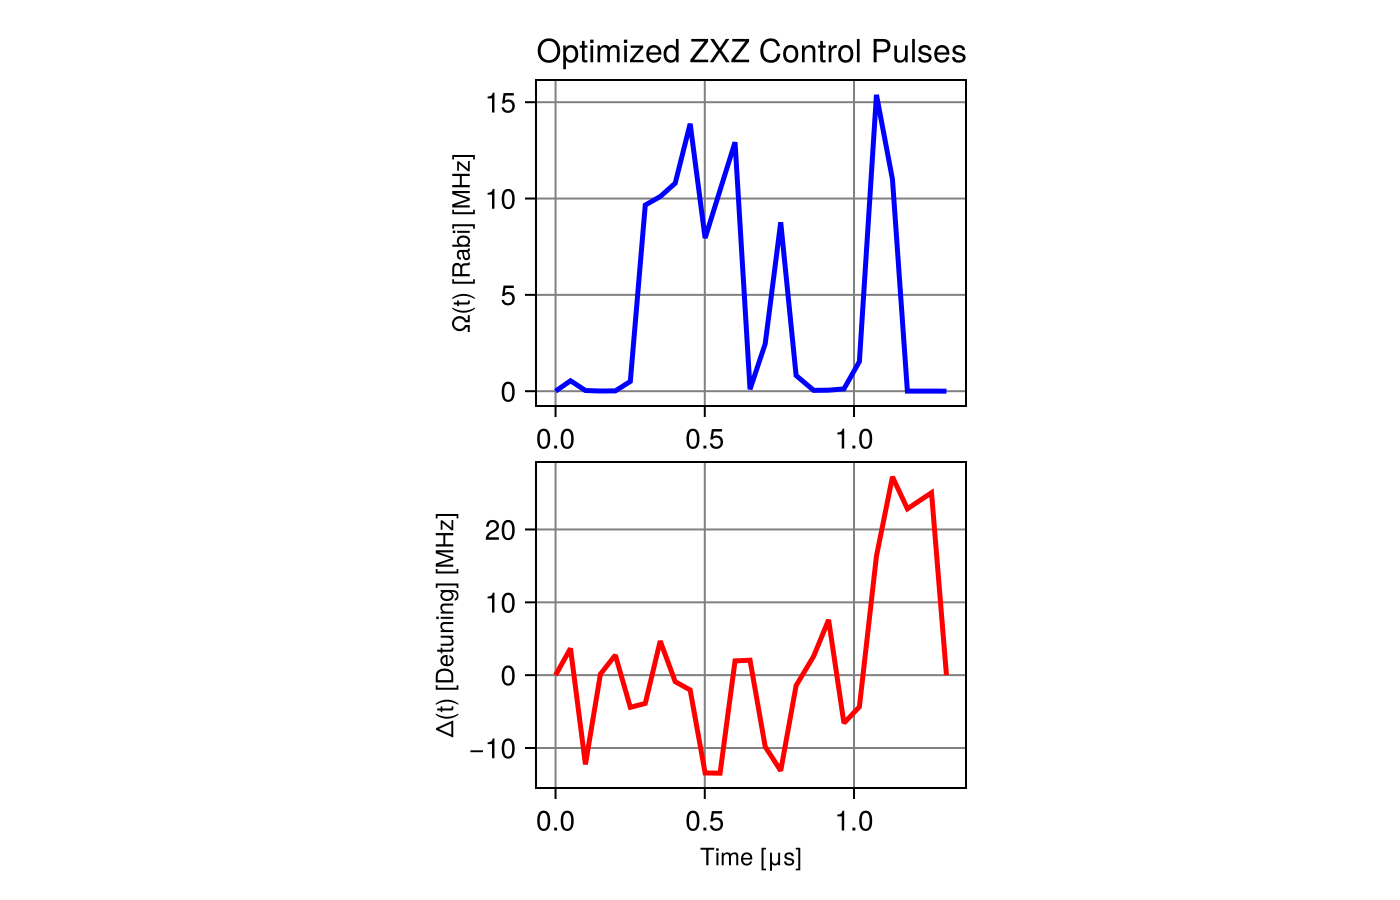

In [ ]:
# Plot the optimized control pulses Ω(t) and Δ(t)
fig_controls = plot_controls(prob.trajectory; 
    title="Optimized ZXZ Control Pulses",
    figsize=(700, 450)
)
fig_controls

## Summary: Engineered ZXZ Hamiltonian Dynamics

The direct trajectory optimization successfully engineered effective three-body ZXZ Hamiltonian dynamics using optimal control of Rydberg atom arrays.

**Key Results:**
- **High-fidelity synthesis**: Achieved $\mathcal{F} > 0.99$ for the target unitary $U_{\text{goal}} = \exp(-i\theta H_{\text{ZXZ}})$
- **Hardware-compliant controls**: Optimized pulses $\{\Omega(t), \Delta(t)\}$ respect experimental constraints
- **Beyond-blockade operation**: Demonstrated effective three-body interactions at $8.9 \, \mu\text{m}$ spacing
- **Global control efficiency**: Used only two global control fields to simulate complex many-body dynamics

**Trace Fidelity Definition:**
The optimization maximizes the trace fidelity:
$$\mathcal{F} = \frac{|\text{tr}(U^\dagger_{\text{goal}} U_{\text{final}})|^2}{d^2}$$
where $d = 2^N$ is the Hilbert space dimension for $N$ qubits.

**Physical Insight (Equation 19):**
The optimization discovers how to modulate the native Rydberg Hamiltonian:
$$\frac{H(t)}{\hbar} = \frac{\Omega(t)}{2} \sum_i (|g_i\rangle\langle r_i| + |r_i\rangle\langle g_i|) - \Delta(t) \sum_i |r_i\rangle\langle r_i| + \sum_{i<j} \frac{C_6}{|r_i - r_j|^6} |r_i\rangle\langle r_i| |r_j\rangle\langle r_j|$$

where:
- $|g_i\rangle$, $|r_i\rangle$ are the ground and Rydberg excited states of atom $i$
- $\Omega(t)$ drives transitions between $|g\rangle \leftrightarrow |r\rangle$ 
- $\Delta(t)$ detunes the Rydberg level energy
- $C_6/|r_i - r_j|^6$ represents van der Waals interactions between excited Rydberg atoms

to generate effective dynamics equivalent to the cluster-Ising model:
$$H_{\text{ZXZ}} = J_{\text{eff}} \sum_j Z_{j-1} X_j Z_{j+1}$$

This demonstrates the power of quantum optimal control for analog quantum simulation, enabling access to exotic many-body phases that are not directly available in the native hardware Hamiltonian.